In [145]:
import httpx
import json
from PIL import Image
from io import BytesIO


class UnsupportedMediaTypeError(Exception): pass
class BadRequestError(Exception): pass
class ForbiddenError(Exception): pass
class NotFoundError(Exception): pass
class RequestTimeoutError(Exception): pass
class InternalServerError(Exception): pass


error_code_and_ex={
    415: UnsupportedMediaTypeError,
    400: BadRequestError,
    403: ForbiddenError,
    404: NotFoundError,
    408: RequestTimeoutError,
    500: InternalServerError,
}

class HttpProxy(object):
    
    def __init__(self, host, port):
        self._host = host
        self._port = port
        self._base_url = 'http://' + self._host + ':' + str(self._port)
        pass

    def get(self, url):
        with httpx.Client() as client:
            response = client.get(self._base_url + url)
            if response.status_code == 200:
                return response.json()
            else:
                raise error_code_and_ex[response.status_code]()
                
        return None

    def post(self, url, data):
        with httpx.Client() as client:
            response = client.post(self._base_url + url,
                                    data=json.dumps(data),
                                   headers={"Content-Type": "application/json"}
                                   )
            if response.status_code == 200:
                return response.json()
            else:
                raise error_code_and_ex[response.status_code]()

        return None

    def patch(self, url, data):
        with httpx.Client() as client:
            response = client.patch(self._base_url + url,
                                    data=json.dumps(data),
                                   headers={"Content-Type": "application/json"}
                                   )
            if response.status_code == 200:
                print(dir(response))
                ct = response.headers.get('content-type', None)
                if ct and ct == 'application/json':
                    return response.json()
                elif ct and ct == 'image/png':
                    return Image.open(BytesIO(response.content)).convert('RGB')
            else:
                raise error_code_and_ex[response.status_code]()

        return None

class SystemProxy(HttpProxy):

    def __init__(self, host, port):
        super().__init__(host, port)
        self._processes = None
        self._containers = None
        self._container_processes = None
        pass

    def profile_full(self, update=False):
        return self.get('/api/system/profile_full')
        
    def processes(self):
        ps = self.get('/api/process/list')
        return ps

    def containers(self, update=False):
        ps = self.get('/api/container/list')
        if self._containers is None or update:
            self._containers = [ContainerProxy(self, p) for p in ps]
        return self._containers

        
    def container_processes(self, update=False):
        ps = self.get('/api/container_process/list')
        if self._container_processes is None or update:
            self._container_processes = [ContainerProcessProxy(self, p) for p in ps]
        return self._container_processes

class ObjectProxy(object):
    
    def __init__(self, system_proxy, class_name, identifier):
        self._system_proxy = system_proxy
        self._identifier = identifier
        self._class_name = class_name
        self._profile = None

    def profile_full(self, update=False):
        if self._profile is None or update:
            self._profile = self._system_proxy.get('/api/' + self._class_name + '/profile_full?identifier=' + self._identifier)
        return self._profile

    def identifier(self, update=False):
        p = self.profile_full(update=update)
        return p['identifier']


class ProcessProxy(ObjectProxy):
    def __init__(self, system_proxy, identifier):
        super().__init__(system_proxy, 'process', identifier)    

    def call(self, *args, **kwargs):
        return self._system_proxy.patch('/api/' + self._class_name + '/call?identifier=' + self._identifier, data=kwargs)

    def execute(self):
        return self._system_proxy.patch('/api/' + self._class_name + '/execute?identifier=' + self._identifier, data={})
        pass

class ContainerProxy(ObjectProxy):
    def __init__(self, system_proxy, identifier):
        super().__init__(system_proxy, 'container', identifier)    


class ContainerProcessProxy(ObjectProxy):
    def __init__(self, system_proxy, identifier):
        super().__init__(system_proxy, 'container_process', identifier)    

    def call(self, **kwargs): 
        return self._system_proxy.patch('/api/' + self._class_name + '/call?identifier=' + self._identifier, data=kwargs)

    def execute(self):
        return self._system_proxy.patch('/api/' + self._class_name + '/execute?identifier=' + self._identifier, data={})
        pass


In [146]:
import yaml
sp = SystemProxy('localhost', 8000)
print(yaml.safe_dump(sp.profile_full(), default_flow_style=False))


class_name: BrokerProxy
core_store:
  broker_factories:
    http:
      class_name: BrokerFactory
      identifier: core://core/BrokerFactory/http::http
      name: http
      type_name: http
    local:
      class_name: BrokerFactory
      identifier: core://core/BrokerFactory/local::local
      name: local
      type_name: local
  brokers:
    http:
      class_name: Broker
      identifier: core://core/Broker/0.0.0.0:8000::http
      name: 0.0.0.0:8000
      type_name: http
    local:
      class_name: Broker
      identifier: core://core/Broker/local::local
      name: local
      type_name: local
  container_factories:
    cv_filesystem:
      class_name: ContainerFactory
      container_factory:
        class_name: ContainerFactory
        identifier: core://core/ContainerFactory/cv_filesystem::cv_filesystem
        name: cv_filesystem
        type_name: cv_filesystem
      identifier: core://core/ContainerFactory/cv_filesystem::cv_filesystem
      name: cv_filesystem
      plugi

In [147]:
ps = sp.container_processes()
p = ps[0]
p.identifier()

'core://core/ContainerProcess/read0::cv_video_capture_read'

In [155]:
d = p.call()


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_content', '_decoder', '_elapsed', '_get_content_decoder', '_num_bytes_downloaded', '_prepare', '_request', 'aclose', 'aiter_bytes', 'aiter_lines', 'aiter_raw', 'aiter_text', 'aread', 'charset_encoding', 'close', 'content', 'cookies', 'default_encoding', 'elapsed', 'encoding', 'extensions', 'has_redirect_location', 'headers', 'history', 'http_version', 'is_client_error', 'is_closed', 'is_error', 'is_informational', 'is_redirect', 'is_server_error', 'is_stream_consumed', 'is_success', 'iter_bytes', 'iter_lines', 'iter_raw', 'iter_text', 'json', 'links', 'next_request', 'num_bytes_downloaded', 'raise_for_status', 're

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_content', '_decoder', '_elapsed', '_get_content_decoder', '_num_bytes_downloaded', '_prepare', '_request', 'aclose', 'aiter_bytes', 'aiter_lines', 'aiter_raw', 'aiter_text', 'aread', 'charset_encoding', 'close', 'content', 'cookies', 'default_encoding', 'elapsed', 'encoding', 'extensions', 'has_redirect_location', 'headers', 'history', 'http_version', 'is_client_error', 'is_closed', 'is_error', 'is_informational', 'is_redirect', 'is_server_error', 'is_stream_consumed', 'is_success', 'iter_bytes', 'iter_lines', 'iter_raw', 'iter_text', 'json', 'links', 'next_request', 'num_bytes_downloaded', 'raise_for_status', 're

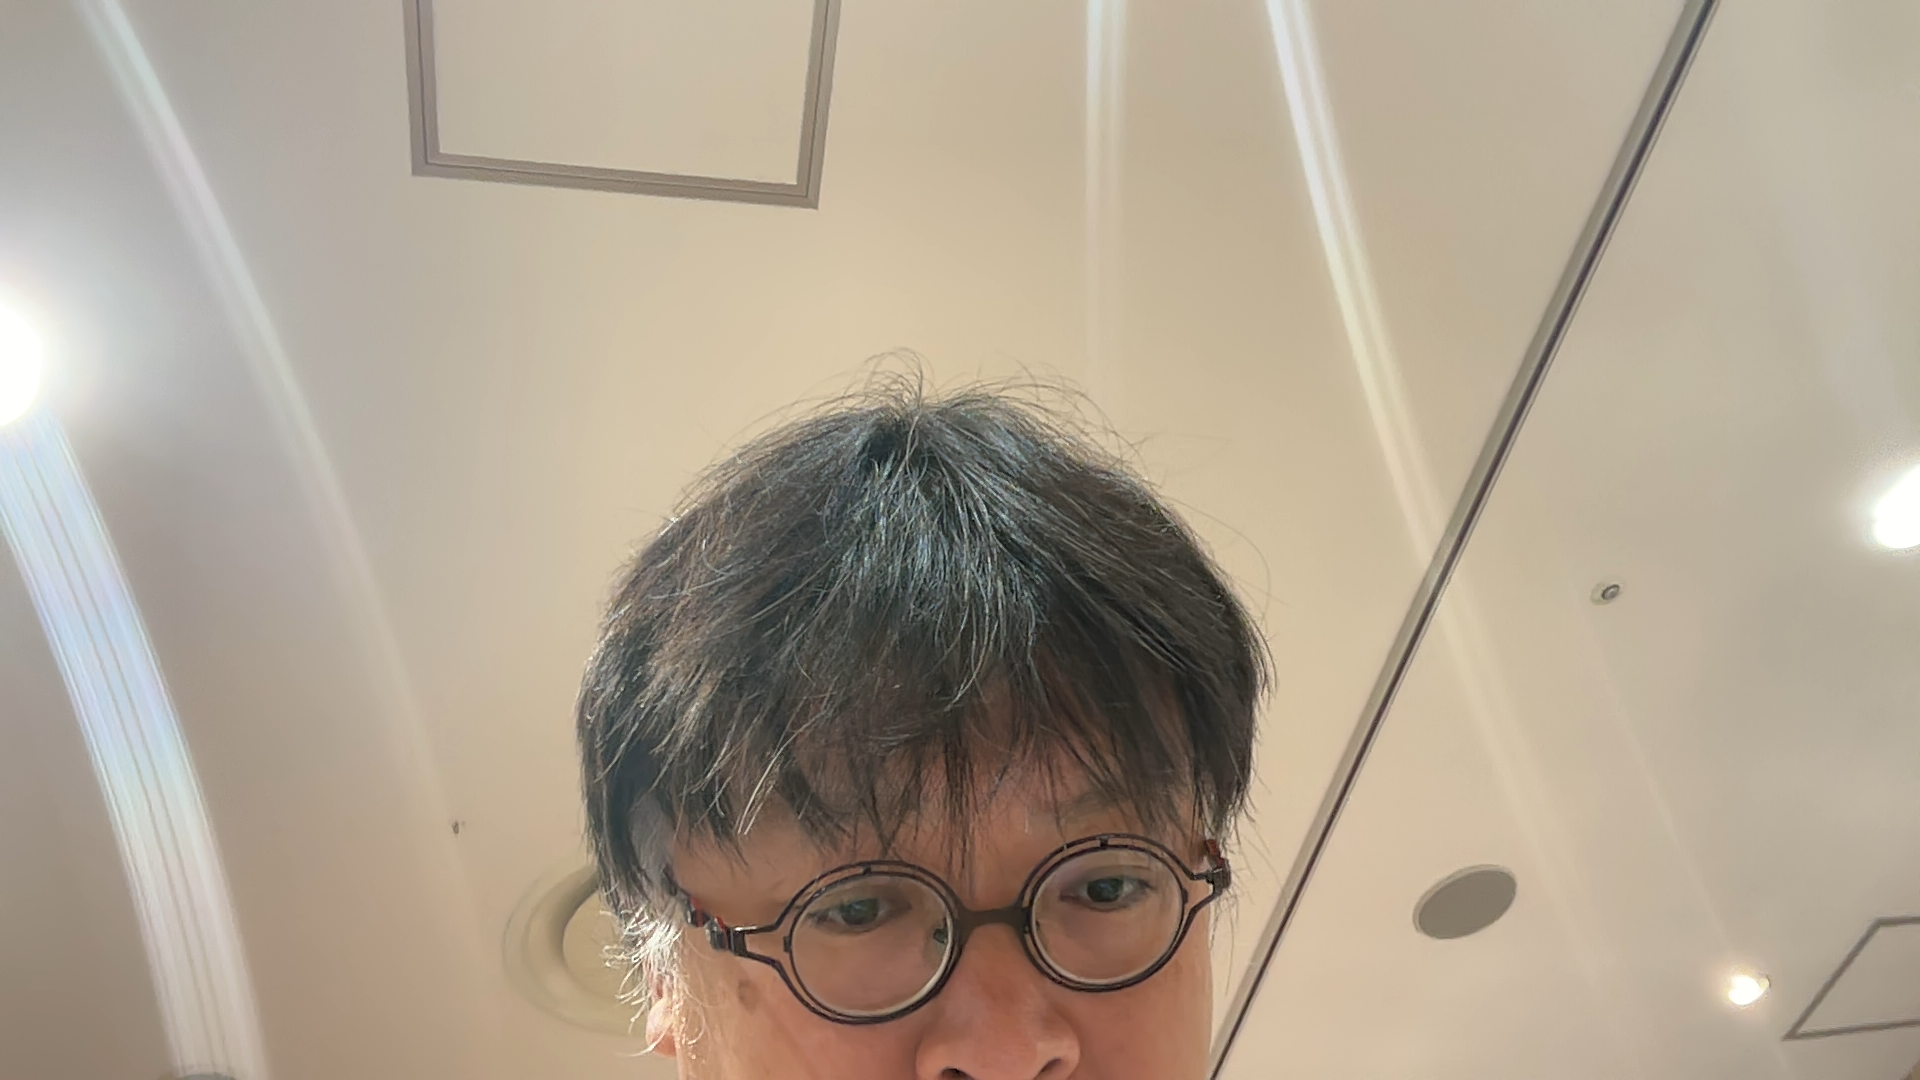

In [157]:
p.execute()





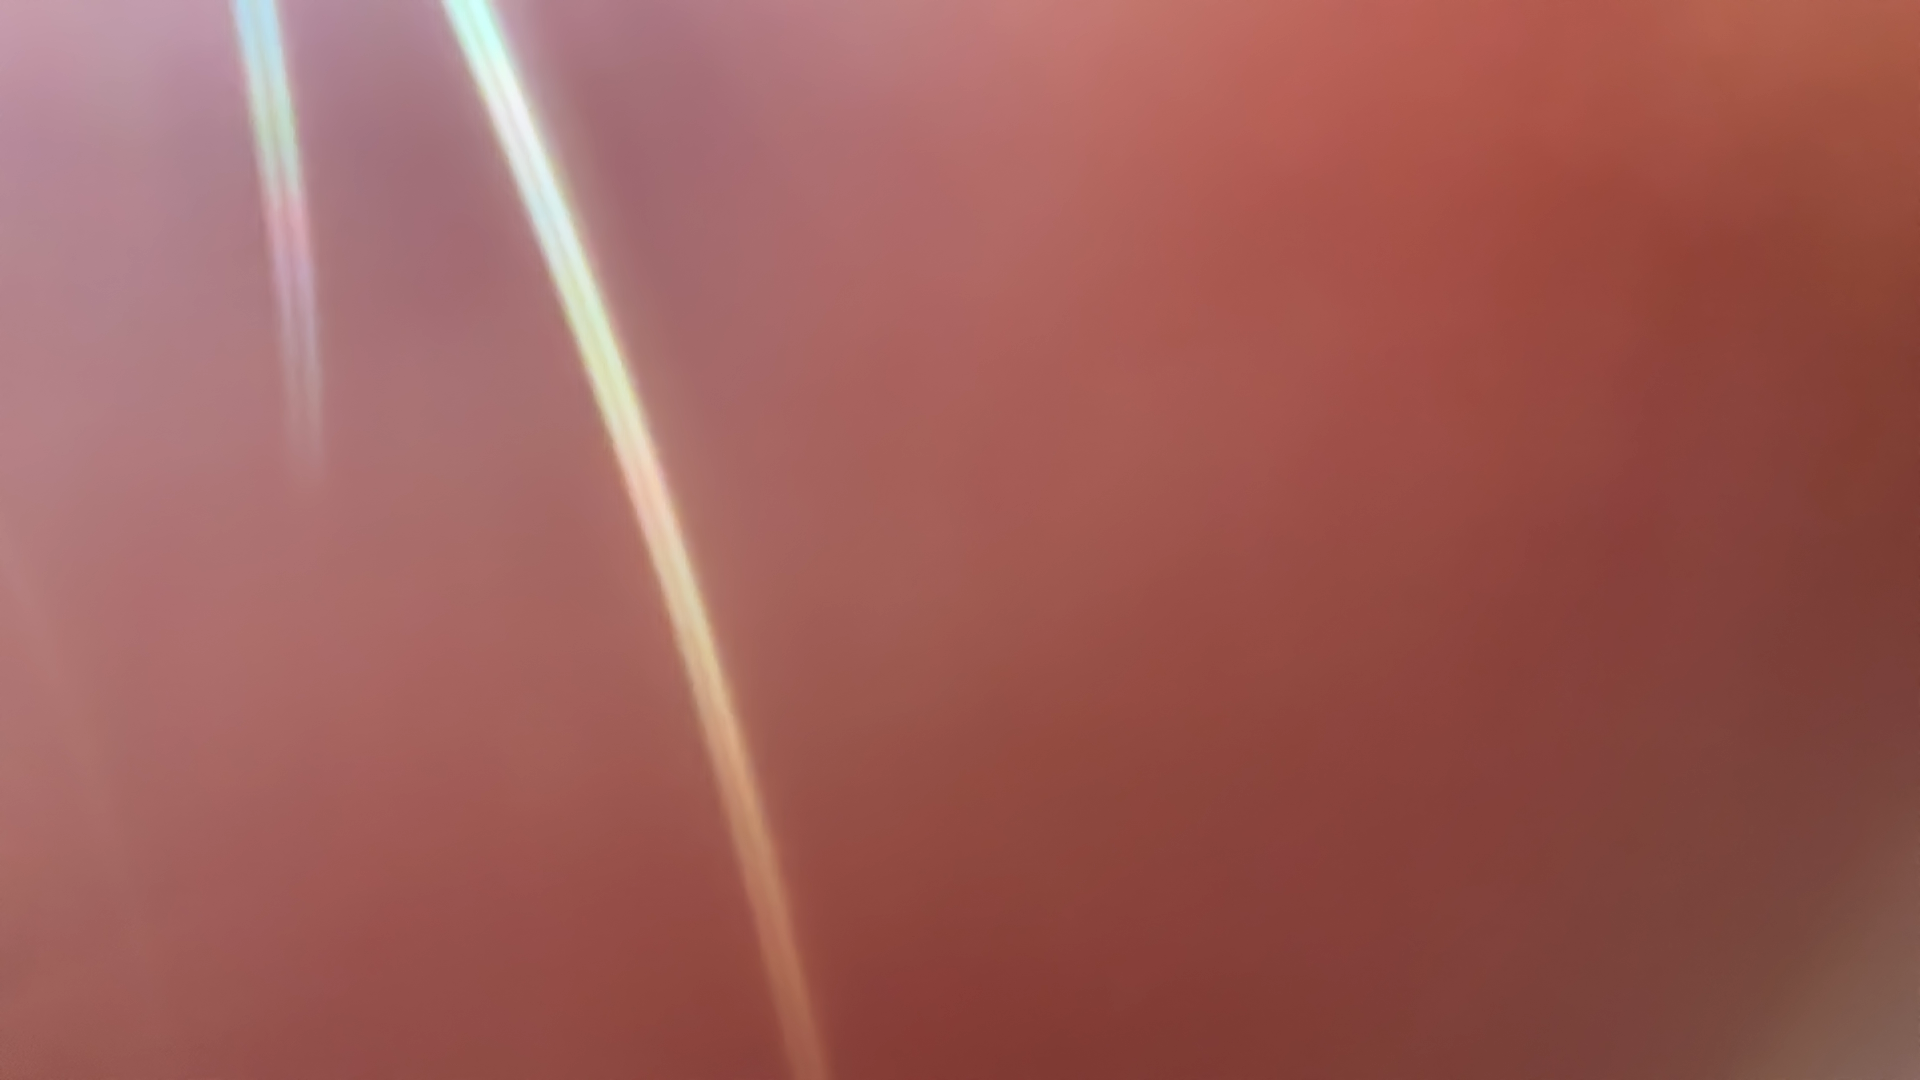

In [158]:
d
